## Orchestrating [Rapids](rapids.ai) workflows with [Prefect](prefect.io)

https://gist.github.com/ayushdg/0c3cc0f52f5a4c49caec9182ee7089f6

This snippet demonstrates a simple Prefect Flow using Rapids to download, read and perform a groupby operation on the [Nyc-Taxi dataset](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page).
For more information on setting up Prefect Flows, refer to the [Prefect docs](https://docs.prefect.io/core/getting_started/first-steps.html#thinking-prefectly) which have excellent [tutorials](https://docs.prefect.io/core/advanced_tutorials/) and [examples](https://github.com/PrefectHQ/prefect/tree/master/examples).


### Table of Contents:
1. [Prefect Task & Flow Setup](#Setting-up-cuDF-tasks)
2. [Single GPU, cuDF tasks](#Single-GPU,-cuDF-tasks)
3. [Multi GPU, cuDF tasks](#Multi-GPU-cuDF)
4. [Multi GPU, dask-cuDF tasks](#Multi-GPU-dask-cuDF)
5. [Scheduling runs at intervals](#We-can-also-schedule-runs-at-intervals)
6. [Next Steps](#Next-Steps)

In [1]:
import cupy

# choose which GPU to use
cupy.cuda.Device(1).use()

In [2]:
# Imports
from prefect import task, Flow, Parameter
import prefect
import cudf
import dask_cudf
import gcsfs
import os
from glob import glob

#### Setting up cuDF tasks

In [3]:
@task()
def download_data(source_bucket, destination_path):
    if not os.path.exists(destination_path) or len(os.listdir(destination_path)) == 0:
        fs = gcsfs.GCSFileSystem()
        fs.get(source_bucket, destination_path)
    return glob(f"{destination_path}/*")


@task()
def read_data(file_name):
    df = cudf.read_csv(file_name)
    return df


@task()
def groupby_chunk(df):
    grouped_df = df.groupby("Passenger_count", sort=False).agg(
        {"Tip_amount": ["count", "sum"]}
    )
    return grouped_df


@task()
def concat_frames(dfs):
    return cudf.concat(dfs)


@task()
def groupby_aggregate(df):
    df = df.reset_index()
    df.columns = ["Passenger_count", "Tip_count", "Tip_sum"]
    grouped_df = df.groupby("Passenger_count", sort=False).agg(
        {"Tip_count": "sum", "Tip_sum": "sum"}
    )
    grouped_df["Tip_mean"] = grouped_df["Tip_sum"] / grouped_df["Tip_count"]
    return grouped_df["Tip_mean"].to_frame()

#### Creating a Prefect flow using their [functional API](https://docs.prefect.io/core/getting_started/first-steps.html#functional-api)

In [4]:
with Flow("cuDF NYTaxi Prefect Flow") as nytaxi_cudf_flow:
    source_bucket = Parameter("source_bucket")
    destination_path = Parameter("destination_path")

    file_list = download_data(source_bucket, destination_path)
    dfs = read_data.map(file_list)  # Maps each downloaded file to a read_data operation
    grouped_dfs = groupby_chunk.map(
        dfs
    )  # Maps each dataframe read to a groupby_chunk operation
    combined_df = concat_frames(grouped_dfs)
    result_df = groupby_aggregate(combined_df)

#### Visualizing the flow

NOTE: graphviz에 문제가 있어서 `sudo apt-get install graphviz` 명령으로 이를 별도로 설치했음

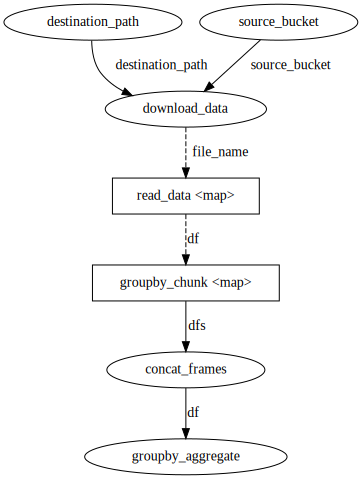

In [5]:
nytaxi_cudf_flow.visualize()

Since the downstream tasks depended on the outputs of the previous tasks, Prefect automatically handled the DAG creation which sequentially map one task to the other. `read_data` and `groupy_chunk` are mapped tasks where each element in the collection of file_names are mapped to these tasks that can run in parallel on a distributed executor such as a [DaskExecutor](https://docs.prefect.io/api/latest/engine/executors.html#daskexecutor)

### Single GPU, cuDF tasks
#### Running the flow and viewing the result

In [6]:
flow_run1 = nytaxi_cudf_flow.run(
    source_bucket="gs://anaconda-public-data/nyc-taxi/csv/2014/green_tripdata*.csv",
    destination_path="./nyc-taxi/green_tripdata/",
)

[2021-05-11 03:07:54+0900] INFO - prefect.FlowRunner | Beginning Flow run for 'cuDF NYTaxi Prefect Flow'
[2021-05-11 03:07:54+0900] INFO - prefect.TaskRunner | Task 'destination_path': Starting task run...
[2021-05-11 03:07:54+0900] INFO - prefect.TaskRunner | Task 'destination_path': Finished task run for task with final state: 'Success'
[2021-05-11 03:07:54+0900] INFO - prefect.TaskRunner | Task 'source_bucket': Starting task run...
[2021-05-11 03:07:54+0900] INFO - prefect.TaskRunner | Task 'source_bucket': Finished task run for task with final state: 'Success'
[2021-05-11 03:07:54+0900] INFO - prefect.TaskRunner | Task 'download_data': Starting task run...
[2021-05-11 03:07:54+0900] INFO - prefect.TaskRunner | Task 'download_data': Finished task run for task with final state: 'Success'
[2021-05-11 03:07:54+0900] INFO - prefect.TaskRunner | Task 'read_data': Starting task run...
[2021-05-11 03:07:54+0900] INFO - prefect.TaskRunner | Task 'read_data': Finished task run for task with 

The output of a flow run can be used to view the results of each stage. 

In this case, we query the result of the task returning `result_df` from the output of `flow_run1`.

In [7]:
flow_run1.result[result_df].result.sort_index()

,Tip_mean
Passenger_count,
0,0.370795
1,1.073249
2,1.178949
3,1.184562
4,1.044996
5,1.072943
6,1.276358
7,0.665341
8,0.843497


### Scaling the Prefect flow to multiple GPUs <a class="anchor" id="Multi-GPU-cuDF"></a>

Prefect has a tight integration with [Dask](https://dask.org) allowing users to scale tasks on a Dask cluster. Rapids also has a tight dask integration to scale workflows to multiple GPUs using [dask-cuda](https://github.com/rapidsai/dask-cuda) which builds on the dask-worker to make it easy to use with cuda enabled GPUs. 

There are multiple ways to scale a Prefect flow out to multiple GPUs (Single and Multi Node)

#### Option 1: Starting a LocalCUDACluster directly using `DaskExecutor` (Single Node only)



In [8]:
from prefect.executors import DaskExecutor

executor = DaskExecutor(
    cluster_class="dask_cuda.LocalCUDACluster",
)

#### Running the flow on multiple GPUs on the node

In [9]:
flow_run2 = nytaxi_cudf_flow.run(
    source_bucket="gs://anaconda-public-data/nyc-taxi/csv/2014/green_tripdata*.csv",
    destination_path="./nyc-taxi/green_tripdata/",
    executor=executor,
)

[2021-05-11 03:08:01+0900] INFO - prefect.FlowRunner | Beginning Flow run for 'cuDF NYTaxi Prefect Flow'
[2021-05-11 03:08:02+0900] INFO - prefect.DaskExecutor | Creating a new Dask cluster with `dask_cuda.local_cuda_cluster.LocalCUDACluster`...
[2021-05-11 03:08:04+0900] INFO - prefect.DaskExecutor | The Dask dashboard is available at http://127.0.0.1:8787/status
[2021-05-11 03:08:33+0900] INFO - prefect.FlowRunner | Flow run SUCCESS: all reference tasks succeeded


In [10]:
# WHY this error? MemoryError: std::bad_alloc: CUDA error at: /home/kywch/miniconda3/envs/saturn/include/rmm/mr/device/cuda_memory_resource.hpp:69: cudaErrorIllegalAddress an illegal memory access was encountered

#flow_run2.result[result_df].result.sort_index()


In [11]:
del (flow_run1, flow_run2)

#### Option 2: Start a dask-cuda cluster through any preferred method and point the `DaskExecutor` object to the scheduler address

For the purposes of this example a single node `LocalCUDACluster` is used. This could easily be replaced by a multi node cluster each running `dask-cuda-worker` and connected to a common `dask-scheduler`.

In [12]:
from dask_cuda import LocalCUDACluster

cluster = LocalCUDACluster()

In [13]:
from prefect.executors import DaskExecutor

executor = DaskExecutor(address=cluster.scheduler_address)

In [14]:
flow_run3 = nytaxi_cudf_flow.run(
    source_bucket="gs://anaconda-public-data/nyc-taxi/csv/2014/green_tripdata*.csv",
    destination_path="./nyc-taxi/green_tripdata/",
    executor=executor,
)

[2021-05-11 03:08:35+0900] INFO - prefect.FlowRunner | Beginning Flow run for 'cuDF NYTaxi Prefect Flow'
[2021-05-11 03:08:35+0900] INFO - prefect.DaskExecutor | Connecting to an existing Dask cluster at tcp://127.0.0.1:33249
[2021-05-11 03:08:59+0900] INFO - prefect.FlowRunner | Flow run SUCCESS: all reference tasks succeeded


---

### Using the dask_cudf api to leverage muti-gpu dataframe operations directly <a class="anchor" id="Multi-GPU-dask-cuDF"></a>

The examples above used `cuDF` a single GPU dataframe library each performing a small task and scaled by scheduling multiple tasks using dask. In the real world, datasets can often be much larger where a single GPU may not be sufficient to perform this unit of work (Task).The dask-cuDF distributed dataframe library (built on top of Dask Dataframe) can also be used with Prefect tasks just as easily.

#### Setting up dask-cuDF tasks

In [15]:
from distributed import worker_client


@task(checkpoint=False)
def dask_read_data(file_names):
    with worker_client() as client:
        return dask_cudf.read_csv(file_names)


@task()
def dask_groupby_task(ddf):
    with worker_client() as client:
        return ddf.groupby("Passenger_count").Tip_amount.mean().compute().to_frame()

#### Creating a dask-cuDF Prefect flow

In [16]:
with Flow("Dask-cuDF NYTaxi Prefect Flow") as nytaxi_dask_cudf_flow:
    source_bucket = Parameter("source_bucket")
    destination_path = Parameter("destination_path")

    file_list = download_data(source_bucket, destination_path)
    ddf = dask_read_data(file_list)
    result_df = dask_groupby_task(ddf)

#### Visualizing the flow

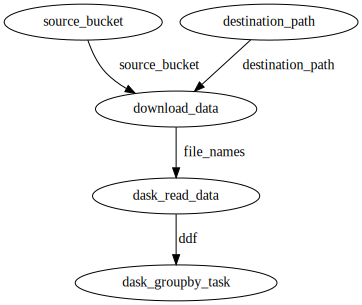

In [17]:
nytaxi_dask_cudf_flow.visualize()

Here `dask_read_data` and `dask_groupby_task` operations work directly with dask-cudf dataframes and use the entire cluster for the task computations.

#### Running the Flow

In [18]:
executor = DaskExecutor(address=cluster.scheduler_address)

flow_run4 = nytaxi_dask_cudf_flow.run(
    source_bucket="gs://anaconda-public-data/nyc-taxi/csv/2014/green_tripdata*.csv",
    destination_path="./nyc-taxi/green_tripdata/",
    executor=executor,
)

[2021-05-11 03:08:59+0900] INFO - prefect.FlowRunner | Beginning Flow run for 'Dask-cuDF NYTaxi Prefect Flow'
[2021-05-11 03:08:59+0900] INFO - prefect.DaskExecutor | Connecting to an existing Dask cluster at tcp://127.0.0.1:33249
[2021-05-11 03:09:01+0900] INFO - prefect.FlowRunner | Flow run SUCCESS: all reference tasks succeeded


In [19]:
# Why this error? -- RuntimeError: merge_sort: failed to synchronize: cudaErrorIllegalAddress: an illegal memory access was encountered

#flow_run4.result[result_df].result.sort_index()

In [20]:
del (flow_run3, flow_run4)

#### We can also schedule runs at intervals

In [21]:
from datetime import timedelta, datetime
from prefect.schedules import IntervalSchedule

# Schedule runs at intervals of 1 minute
schedule = IntervalSchedule(
    start_date=datetime.utcnow() + timedelta(seconds=1),
    interval=timedelta(minutes=1),
)

nytaxi_dask_cudf_flow.schedule = schedule

In [22]:
interval_run = nytaxi_dask_cudf_flow.run(
    source_bucket="gs://anaconda-public-data/nyc-taxi/csv/2014/green_tripdata*.csv",
    destination_path="./nyc-taxi/green_tripdata/",
    executor=executor,
)

[2021-05-11 03:09:01+0900] INFO - prefect.Dask-cuDF NYTaxi Prefect Flow | Waiting for next scheduled run at 2021-05-10T18:09:02.602572+00:00
[2021-05-11 03:09:02+0900] INFO - prefect.FlowRunner | Beginning Flow run for 'Dask-cuDF NYTaxi Prefect Flow'
[2021-05-11 03:09:02+0900] INFO - prefect.DaskExecutor | Connecting to an existing Dask cluster at tcp://127.0.0.1:33249
[2021-05-11 03:09:05+0900] INFO - prefect.FlowRunner | Flow run SUCCESS: all reference tasks succeeded
[2021-05-11 03:09:05+0900] INFO - prefect.Dask-cuDF NYTaxi Prefect Flow | Waiting for next scheduled run at 2021-05-10T18:10:02.602572+00:00
[2021-05-11 03:10:02+0900] INFO - prefect.FlowRunner | Beginning Flow run for 'Dask-cuDF NYTaxi Prefect Flow'
[2021-05-11 03:10:02+0900] INFO - prefect.DaskExecutor | Connecting to an existing Dask cluster at tcp://127.0.0.1:33249
[2021-05-11 03:10:05+0900] INFO - prefect.FlowRunner | Flow run SUCCESS: all reference tasks succeeded
[2021-05-11 03:10:05+0900] INFO - prefect.Dask-cuD

KeyboardInterrupt: 

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


---

### Next steps: Prefect [server orchestration](https://docs.prefect.io/orchestration/) <a class="anchor" id="Next-Steps"></a>

The existing flow can be registered to a Prefect backend (server or cloud) which can be used to monitor, schedule and execute multiple Prefect flows across project and environments.

When using the Local server as the backend, the flow can be modified as follows:
- Setup an execution environment for the flow eg: `LocalEnvironment`

```python
from prefect.environments import LocalEnvironment
from prefect.engine.executors import DaskExecutor

executor = DaskExecutor(address="{scheduler_address}")
environment = LocalEnvironment(executor=executor)
```

- Register the flow to a project
    ```python
    flow.register("project_name")
    ```

